### Find inverse traces
This notebook shows now to predict inverse trace using first break piking model and Random Trees.

In [1]:
import sys
import torch
import segyio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

sys.path.append('../..')

from seismicpro.batchflow import Pipeline, Dataset, B
from seismicpro.batchflow.models.torch import TorchModel
from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex, 
                            merge_picking_files, seismic_plot, KNNIndex)

Firstly we load pretrained TCN model.

In [2]:
model_path = '/notebooks/kalashnikov/geolog/models/First_break_picking/picks_modelUNet_ker5.dill'

model_ppl = Pipeline().init_model('dynamic', TorchModel, 'my_model',
                            config={'load' : {'path' : model_path},
                                    'build': False})

model = model_ppl.get_model_by_name('my_model').model

path_raw = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy'

index = (FieldIndex(name='raw', path=path_raw, extra_headers=['offset']))

Now let's create a batch class instance. This batch class has a function to generate a dataset. The dataset consist the following params:
* the amplitude value at the point of the first break picking
* the difference between amplitude value on the N traces of neighors.
* offset
* the difference between time value of the first break picking on the N traces of neighbors
* correlation between part of traces with first break picking points.

In [3]:
def crop_trace(trace, pred, size):
    lenght = len(trace)
    if lenght < pred + int(size/2):
        left = lenght - size
        right = lenght
    elif pred - int(size/2) < 0:
        left = 0
        right = size
    else:
        left = pred - int(size/2)
        right = pred + int(size/2)
    return trace[left: right]

In [4]:
from seismicpro.batchflow import action, inbatch_parallel
predict = lambda x: np.argmax(np.argmax(model(x).cpu().detach().numpy(), axis=1), axis=1)

def crop_trace(trace, pred, size):
    lenght = len(trace)
    if lenght < pred + int(size/2):
        left = lenght - size
        right = lenght
    elif pred - int(size/2) < 0:
        left = 0
        right = size
    else:
        left = pred - int(size/2)
        right = pred + int(size/2)
    return np.array(trace[left: right])

class InvBatch(SeismicBatch):
    @action
    @inbatch_parallel(init='_init_component')
    def generate_inverse_dataset(self, index, model, num_neig, src, mode='generate', dst=None, size=20):
        """Generate dataset using given model and field data.
        
        Parameters
        ----------
        model : torch model
            model to predict first break picking.
        num_neig : int
            number of neighbours to compare model results.
        src : str
            component's name with data
        mode : str
            There are two generation mode - 'generate' and 'predict'.
            If mode = 'generate' then function save dataset with equal number
            of normal and inverce traces to dst. If 'predict' then small number of traces
            will be inversed and dataset will have the same size as input field.
        dst : str or None, optional
            component's name to save resulted data.
        size : int
            size of vectors on the basis of which correlation is considered.
        """

        if mode not in ['generate', 'predict']:
            raise ValueError('Incorrect value of "mode" parameter.')

        dst = src if dst is None else dst
        pos = self.get_pos(None, src, index)
        field = getattr(self, src)[pos]
        offset = np.array(self.index.get_df(index=index)['offset'])
        
        pred = []
        for trace in field:
            t = torch.Tensor(trace).reshape(1, 1, trace.shape[0]).to('cuda')
            inv_t = torch.Tensor(-trace).reshape(1, 1, trace.shape[0]).to('cuda')
            pred.append([predict(t)[0], predict(inv_t)[0]])
        data = []
        
        inv_ix = np.zeros(field.shape[0])
        mask = np.random.choice(range(len(inv_ix)), size=np.random.randint(1, 5))
        inv_ix[mask] = 1
        
        for i, (trace, inv_trace, norm_predict, off) in enumerate(zip(field, -field,
                                                                      pred, offset)):
            traces = [(trace, norm_predict[0]), (inv_trace, norm_predict[1])]
            for j, (tr, pr) in enumerate(traces):
                if j == 1 and mode == 'predict' and inv_ix[i] != 1:
                    continue

                amp_val = tr[pr]
                
                corr_vec = crop_trace(tr, pr, size)
                amp_left = []
                amp_right = []
                inv_amp_left = []
                inv_amp_right = []
                diff_pred_left = []
                diff_pred_right = []
                inv_diff_pred_left = []
                inv_diff_pred_right = []
                corr_left = []
                corr_right = []
                inv_corr_left = []
                inv_corr_right = []
                for neig in range(1, num_neig+1):
                    if i >= neig and i < len(field) - neig:
                        amp_left.append(amp_val - field[i-neig][pred[i-neig][0]])
                        amp_right.append(amp_val - field[i+neig][pred[i+neig][0]])
                        inv_amp_left.append(amp_val - (-1)*field[i-neig][pred[i-neig][1]])
                        inv_amp_right.append(amp_val - (-1)*field[i+neig][pred[i+neig][1]])
                        diff_pred_left.append(pred[i][j] - pred[i-neig][0])
                        diff_pred_right.append(pred[i][j] - pred[i+neig][0])
                        inv_diff_pred_left.append(pred[i][j] - pred[i-neig][1])
                        inv_diff_pred_right.append(pred[i][j] - pred[i+neig][1])
                        
                        left_vec = crop_trace(field[i-neig], pred[i-neig][0], size)
                        right_vec = crop_trace(field[i+neig], pred[i+neig][0], size)
                        inv_left_vec = crop_trace(field[i-neig], pred[i-neig][1], size)
                        inv_right_vec = crop_trace(field[i+neig], pred[i+neig][1], size)
                        corr_left.append(np.corrcoef(left_vec, corr_vec)[0][1])
                        corr_right.append(np.corrcoef(right_vec, corr_vec)[0][1])
                        inv_corr_left.append(np.corrcoef(inv_left_vec, corr_vec)[0][1])
                        inv_corr_right.append(np.corrcoef(inv_right_vec, corr_vec)[0][1])

                    elif i < neig:
                        amp_left.append(0)
                        diff_pred_left.append(0)
                        inv_amp_left.append(0)
                        inv_diff_pred_left.append(0)
                        corr_left.append(0)
                        inv_corr_left.append(0)
                        amp_right.append(amp_val - field[i+neig][pred[i+neig][0]])
                        inv_amp_right.append(amp_val - (-1)*field[i+neig][pred[i+neig][1]])
                        diff_pred_right.append(pred[i][j] - pred[i+neig][0])
                        inv_diff_pred_right.append(pred[i][j] - pred[i+neig][1])
                        
                        right_vec = crop_trace(field[i+neig], pred[i+neig][0], size)
                        inv_right_vec = crop_trace(field[i+neig], pred[i+neig][1], size)
                        corr_right.append(np.corrcoef(right_vec, corr_vec)[0][1])
                        inv_corr_right.append(np.corrcoef(inv_right_vec, corr_vec)[0][1])
                    else:
                        amp_right.append(0)
                        diff_pred_right.append(0)
                        inv_amp_right.append(0)
                        inv_diff_pred_right.append(0)
                        corr_right.append(0)
                        inv_corr_right.append(0)
                        amp_left.append(amp_val - field[i-neig][pred[i-neig][0]])
                        diff_pred_left.append(pred[i][j] - pred[i-neig][0])
                        amp_left.append(amp_val - field[i-neig][pred[i-neig][0]])
                        inv_diff_pred_left.append(pred[i][j] - pred[i-neig][1])
                        
                        left_vec = crop_trace(field[i-neig], pred[i-neig][0], size)
                        inv_left_vec = crop_trace(field[i-neig], pred[i-neig][1], size)
                        corr_left.append(np.corrcoef(left_vec, corr_vec)[0][1])
                        inv_corr_left.append(np.corrcoef(inv_left_vec, corr_vec)[0][1])

                data.append([amp_val, off, *amp_left, *inv_amp_left, *amp_right, *inv_amp_right,
                             *diff_pred_left, *inv_diff_pred_left, *diff_pred_right, *inv_diff_pred_right,
                             *corr_left, *corr_right, *inv_corr_left, *inv_corr_right,
                             j])
        getattr(self, dst)[pos] = data
        return self

Define pipeline and generate dataset.

In [5]:
def f(a):
    return (a - a.mean())/a.std()

ppl = (Dataset(index, InvBatch).p
         .load(components='raw', fmt='segy')
         .init_variable('diff', init_on_each_run=list)
         .apply_transform(f, src='raw')
         .generate_inverse_dataset(model, num_neig=10, src='raw', dst='diff')
         .update_variable('diff', B('diff'), mode='e')
        )

Split dataset on train and test.

In [6]:
%%time
z = ppl.next_batch(15)

diff = ppl.get_variable('diff')
data = np.concatenate(diff)

np.random.shuffle(data)
dataset, target = data[:,:-1], data[:,-1]
dataset = np.nan_to_num(dataset)

X_train, X_test, y_train, y_test = train_test_split(dataset, target)

CPU times: user 14min 48s, sys: 3min 50s, total: 18min 39s
Wall time: 9min 28s


Train Random Forest.

In [7]:
tree = RandomForestClassifier()
tree.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Now let's check the model quality. 

In [8]:
pred = tree.predict(X_test)
print(classification_report(y_test, pred))
print('Accuracy score: {:.3}'.format(accuracy_score(y_test, pred)))

             precision    recall  f1-score   support

        0.0       0.95      0.98      0.96      3086
        1.0       0.98      0.95      0.96      3198

avg / total       0.96      0.96      0.96      6284

Accuracy score: 0.962


And graw feature importance.

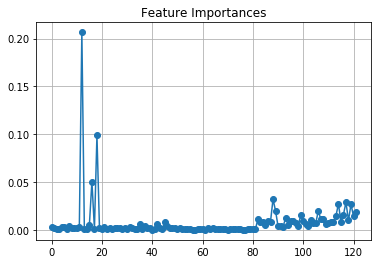

In [9]:
plt.title('Feature Importances')
plt.plot(range(len(tree.feature_importances_)), tree.feature_importances_, marker='o')
plt.grid()

Let's inverse some traces in one filed and check how the model will find inverse traces.

In [10]:
ppl = (Dataset(index, InvBatch).p
         .load(components='raw', fmt='segy')
         .init_variable('diff', init_on_each_run=list)
         .apply_transform(f, src='raw')
         .generate_inverse_dataset(model, num_neig=10, src='raw', mode='predict', dst='diff')
         .update_variable('diff', B('diff'), mode='e')
        )

In [11]:
batch = ppl.next_batch(1)

pred_diff = ppl.get_variable('diff')
pred_data = np.concatenate(pred_diff)

pred_dataset, pred_target = pred_data[:, : -1], pred_data[:, -1]
pred_dataset = np.nan_to_num(pred_dataset)

pred = tree.predict(pred_dataset)
print(classification_report(pred_target, pred))
print('Accuracy score: {:.3}'.format(accuracy_score(pred_target, pred)))
print('Number of inverse traces: {}\nNumber of predict inverse traces: {}'.format(sum(pred_target),
                                                                                  sum(pred)))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       840
        1.0       0.75      1.00      0.86         3

avg / total       1.00      1.00      1.00       843

Accuracy score: 0.999
Number of inverse traces: 3.0
Number of predict inverse traces: 4.0


One can notice that there are many false positive predictions.